In [1]:
!pip install transformers datasets sentencepiece sacrebleu nltk accelerate tqdm

import os, random
import pandas as pd
import numpy as np
import torch
import re
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import MarianMTModel, MarianTokenizer
from tqdm.auto import tqdm

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# Define Traditional Generators
# -------------------------------------
class SyntheticDataGenerator:
    def generate(self, texts):
        raise NotImplementedError

class BackTranslationGenerator(SyntheticDataGenerator):
    def __init__(self, src="en", tgt="fr"):
        self.en_fr_tok = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{tgt}")
        self.en_fr_model = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{tgt}")
        self.fr_en_tok = MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-{src}")
        self.fr_en_model = MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-{src}")

    def translate(self, batch, model, tok):
        tokens = tok(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)
        outs = model.generate(**tokens)
        return [tok.decode(o, skip_special_tokens=True) for o in outs]

    def generate(self, texts):
        augmented = []
        for txt in tqdm(texts, desc="Back-Translating", unit="example"):
            fr   = self.translate([txt], self.en_fr_model, self.en_fr_tok)[0]
            back = self.translate([fr], self.fr_en_model, self.fr_en_tok)[0]
            augmented.append(back if back != txt else txt)
        return augmented

class SynonymReplacementGenerator(SyntheticDataGenerator):
    def __init__(self, p=0.3):
        self.p = p

    def get_syns(self, w):
        syns = set(lemma.name().replace('_',' ') for syn in wordnet.synsets(w) for lemma in syn.lemmas())
        return list(syns - {w})

    def generate(self, texts):
        out = []
        for txt in tqdm(texts, desc="Synonym Replacement", unit="example"):
            words = word_tokenize(txt)
            n = max(1, int(len(words)*self.p))
            idxs = random.sample(range(len(words)), n)
            for i in idxs:
                syns = self.get_syns(words[i])
                if syns:
                    words[i] = random.choice(syns)
            out.append(" ".join(words))
        return out

class WordDeletionGenerator(SyntheticDataGenerator):
    def __init__(self, p=0.1):
        self.p = p

    def generate(self, texts):
        out = []
        for txt in tqdm(texts, desc="Word Deletion", unit="example"):
            words = word_tokenize(txt)
            new = [w for w in words if random.random()>self.p]
            if len(new)<2: new = words[:2]
            out.append(" ".join(new))
        return out

# class SentenceSwapGenerator(SyntheticDataGenerator):
#     def generate(self, texts):
#         out = []
#         for txt in tqdm(texts, desc="Sentence Swap", unit="example"):
#             sents = sent_tokenize(txt)
#             if len(sents)>1:
#                 random.shuffle(sents)
#             out.append(" ".join(sents))
#         return out

class SentenceSwapGenerator(SyntheticDataGenerator):
    def __init__(self, swap_ratio=0.10):
        self.swap_ratio = swap_ratio

    def generate(self, texts):
        out = []
        for txt in tqdm(texts, desc="Sentence Word Swap", unit="example"):
            # Split into sentences preserving punctuation
            sentences = sent_tokenize(txt)
            modified_sents = []

            for sent in sentences:
                # Tokenize while keeping punctuation as separate tokens
                tokens = word_tokenize(sent)

                # Find indices of non-punctuation words
                word_indices = [
                    i for i, token in enumerate(tokens)
                    if token.isalnum()  # Exclude punctuation-only tokens
                ]

                if len(word_indices) < 2:
                    modified_sents.append(sent)
                    continue

                # Calculate max swaps based on number of actual words
                max_swaps = max(1, int(len(word_indices) * self.swap_ratio))
                swap_count = 0
                modified = tokens.copy()

                # Perform swaps only on word indices
                while swap_count < max_swaps:
                    i, j = random.sample(word_indices, 2)

                    # Swap words while leaving punctuation in place
                    modified[i], modified[j] = modified[j], modified[i]
                    swap_count += 1

                # Reconstruct sentence with proper punctuation spacing
                new_sent = " ".join(modified)
                new_sent = re.sub(r'\s+([.,!?;])', r'\1', new_sent)  # Fix punctuation
                new_sent = re.sub(r' ([’\'"]) ', r'\1', new_sent)  # Fix quotes
                modified_sents.append(new_sent)

            # Rebuild full text from modified sentences
            out.append(" ".join(modified_sents))

        return out
class CombinedGenerator(SyntheticDataGenerator):
    def __init__(self):
        self.mods = [
            SynonymReplacementGenerator(),
            WordDeletionGenerator(),
            SentenceSwapGenerator()
        ]
    def generate(self, texts):
        curr = texts[:]
        for m in self.mods:
            curr = m.generate(curr)
        return curr


In [3]:
# Build HuggingFace Dataset
class TextDataset(TorchDataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_len)
        self.labels = labels

    def __len__(self): return len(self.labels)

    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }


In [4]:
# Training
def train_and_eval(train_texts, train_labels, test_texts, test_labels,
                   model_name="bert-base-uncased", output_dir="./tmp"):
    tok   = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(train_labels)))

    train_ds = TextDataset(train_texts, train_labels, tok)
    test_ds  = TextDataset(test_texts,  test_labels,  tok)

    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        # evaluation_strategy="epoch",
        save_strategy="no",
        logging_steps=250,
        disable_tqdm=False,
        learning_rate=2e-5,
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics
    )
    trainer.train()


    preds_output = trainer.predict(test_ds)
    y_true = preds_output.label_ids
    y_pred = np.argmax(preds_output.predictions, axis=1)

    print("Classification Report:")
    print(classification_report(
        y_true,
        y_pred,
        digits=4
    ))

    return {
        "eval_accuracy": accuracy_score(y_true, y_pred),
        "eval_f1_macro": f1_score(y_true, y_pred, average="macro")
    }


In [5]:
# Load Datasets
from sklearn.model_selection import train_test_split

datasets = {
    "HATE_nohate":   ("hate_speech_0_1-(minority_class_hate).csv", "speech", "label"),
    "Sarcasm_Detection": ("sarcastic_numeric_labels(minority_class_sarcastic).csv",     "headline",     "label"),
}

splits = {}
for name, (fn, text_col, label_col) in datasets.items():
    df = pd.read_csv(fn)

    # lm = label_maps[name]
    # if lm is not None:
    #     df[label_col] = df[label_col].map(lm)


    texts = df[text_col].tolist()
    labs  = df[label_col].tolist()
    tx, vx, ty, vy = train_test_split(texts, labs, test_size=0.2, random_state=42, stratify=labs)
    splits[name] = (tx, ty, vx, vy)
    print(f"{name} original train distribution: {pd.Series(ty).value_counts().to_dict()}")
    print(f"{name} val   distribution: {pd.Series(vy).value_counts().to_dict()}")


HATE_nohate original train distribution: {0: 800, 1: 160}
HATE_nohate val   distribution: {0: 200, 1: 40}
Sarcasm_Detection original train distribution: {0: 800, 1: 160}
Sarcasm_Detection val   distribution: {0: 200, 1: 40}


In [7]:
generators = {
    "back_translation": BackTranslationGenerator(),
    "synonym":          SynonymReplacementGenerator(),
    "deletion":         WordDeletionGenerator(),
    "swap":             SentenceSwapGenerator(),
    "combined":         CombinedGenerator()
}

results = {}
for ds_name, (train_texts, train_labels, val_texts, val_labels) in splits.items():
    print(f"\n=== DATASET: {ds_name} ===")


    # Create directory for augmented samples
    aug_dir = f"augmented_samples/{ds_name}"
    os.makedirs(aug_dir, exist_ok=True)


    # 1) Baseline on imbalanced data
    print("Baseline:")
    results[(ds_name, "baseline")] = train_and_eval(
        train_texts, train_labels, val_texts, val_labels,
        output_dir=f"./{ds_name}_baseline"
    )

    # 2) For each traditional method
    for method_name, gen in generators.items():
        print(f"\nAugmenting minority class with {method_name}…")

        # a) Identify minority label in the training set
        counts = pd.Series(train_labels).value_counts()
        minority_label = counts.idxmin()

        # b) Collect all texts of only the minority class
        minority_texts = [t for t, l in zip(train_texts, train_labels) if l == minority_label]

        # c) Generate synthetic samples
        aug_texts  = gen.generate(minority_texts)
        aug_labels = [minority_label] * len(aug_texts)

        print(f"Generated {len(aug_texts)} synthetic samples.")
        print(f"Augmented train distribution: {pd.Series(aug_labels).value_counts().to_dict()}")

        # Store augmented samples
        aug_df = pd.DataFrame({
            'text': minority_texts[:len(aug_texts)],
            'transformed_text': aug_texts,
            'label': aug_labels,
        })

        #save
        filename = f"{aug_dir}/{method_name}_aug.csv"
        aug_df.to_csv(filename, index=False)
        print(f"Saved {len(aug_df)} augmented samples to {filename}")

        # d) Append synthetic samples to training data
        new_texts = train_texts + aug_texts
        new_labels= train_labels + aug_labels

        # e) Retrain & evaluate
        results[(ds_name, method_name)] = train_and_eval(
            new_texts, new_labels, val_texts, val_labels,
            output_dir=f"./{ds_name}_{method_name}"
        )

# Display summary of metrics
import pprint
pprint.pprint(results)

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")



=== DATASET: HATE_nohate ===
Baseline:


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8750    0.9800    0.9245       200
           1     0.7500    0.3000    0.4286        40

    accuracy                         0.8667       240
   macro avg     0.8125    0.6400    0.6765       240
weighted avg     0.8542    0.8667    0.8419       240


Augmenting minority class with back_translation…


Back-Translating:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/HATE_nohate/back_translation_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.9271    0.8900    0.9082       200
           1     0.5417    0.6500    0.5909        40

    accuracy                         0.8500       240
   macro avg     0.7344    0.7700    0.7495       240
weighted avg     0.8628    0.8500    0.8553       240


Augmenting minority class with synonym…


Synonym Replacement:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/HATE_nohate/synonym_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8972    0.9600    0.9275       200
           1     0.6923    0.4500    0.5455        40

    accuracy                         0.8750       240
   macro avg     0.7948    0.7050    0.7365       240
weighted avg     0.8630    0.8750    0.8639       240


Augmenting minority class with deletion…


Word Deletion:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/HATE_nohate/deletion_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.9082    0.9400    0.9238       200
           1     0.6364    0.5250    0.5753        40

    accuracy                         0.8708       240
   macro avg     0.7723    0.7325    0.7496       240
weighted avg     0.8629    0.8708    0.8658       240


Augmenting minority class with swap…


Sentence Word Swap:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/HATE_nohate/swap_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8925    0.9550    0.9227       200
           1     0.6538    0.4250    0.5152        40

    accuracy                         0.8667       240
   macro avg     0.7732    0.6900    0.7189       240
weighted avg     0.8527    0.8667    0.8548       240


Augmenting minority class with combined…


Synonym Replacement:   0%|          | 0/160 [00:00<?, ?example/s]

Word Deletion:   0%|          | 0/160 [00:00<?, ?example/s]

Sentence Word Swap:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/HATE_nohate/combined_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8894    0.9650    0.9257       200
           1     0.6957    0.4000    0.5079        40

    accuracy                         0.8708       240
   macro avg     0.7925    0.6825    0.7168       240
weighted avg     0.8571    0.8708    0.8560       240


=== DATASET: Sarcasm_Detection ===
Baseline:


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8853    0.9650    0.9234       200
           1     0.6818    0.3750    0.4839        40

    accuracy                         0.8667       240
   macro avg     0.7836    0.6700    0.7037       240
weighted avg     0.8514    0.8667    0.8502       240


Augmenting minority class with back_translation…


Back-Translating:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/Sarcasm_Detection/back_translation_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.9175    0.9450    0.9310       200
           1     0.6765    0.5750    0.6216        40

    accuracy                         0.8833       240
   macro avg     0.7970    0.7600    0.7763       240
weighted avg     0.8773    0.8833    0.8795       240


Augmenting minority class with synonym…


Synonym Replacement:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/Sarcasm_Detection/synonym_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.9019    0.9650    0.9324       200
           1     0.7308    0.4750    0.5758        40

    accuracy                         0.8833       240
   macro avg     0.8163    0.7200    0.7541       240
weighted avg     0.8734    0.8833    0.8729       240


Augmenting minority class with deletion…


Word Deletion:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/Sarcasm_Detection/deletion_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.9087    0.9450    0.9265       200
           1     0.6562    0.5250    0.5833        40

    accuracy                         0.8750       240
   macro avg     0.7825    0.7350    0.7549       240
weighted avg     0.8666    0.8750    0.8693       240


Augmenting minority class with swap…


Sentence Word Swap:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/Sarcasm_Detection/swap_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8784    0.9750    0.9242       200
           1     0.7222    0.3250    0.4483        40

    accuracy                         0.8667       240
   macro avg     0.8003    0.6500    0.6862       240
weighted avg     0.8524    0.8667    0.8449       240


Augmenting minority class with combined…


Synonym Replacement:   0%|          | 0/160 [00:00<?, ?example/s]

Word Deletion:   0%|          | 0/160 [00:00<?, ?example/s]

Sentence Word Swap:   0%|          | 0/160 [00:00<?, ?example/s]

Generated 160 synthetic samples.
Augmented train distribution: {1: 160}
Saved 160 augmented samples to augmented_samples/Sarcasm_Detection/combined_aug.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

           0     0.8818    0.9700    0.9238       200
           1     0.7000    0.3500    0.4667        40

    accuracy                         0.8667       240
   macro avg     0.7909    0.6600    0.6952       240
weighted avg     0.8515    0.8667    0.8476       240

{('HATE_nohate', 'back_translation'): {'eval_accuracy': 0.85,
                                       'eval_f1_macro': 0.7495361781076066},
 ('HATE_nohate', 'baseline'): {'eval_accuracy': 0.8666666666666667,
                               'eval_f1_macro': 0.6765498652291105},
 ('HATE_nohate', 'combined'): {'eval_accuracy': 0.8708333333333333,
                               'eval_f1_macro': 0.7167979901792851},
 ('HATE_nohate', 'deletion'): {'eval_accuracy': 0.8708333333333333,
                               'eval_f1_macro': 0.7495876947931742},
 ('HATE_nohate', 'swap'): {'eval_accuracy': 0.8666666666666667,
                           'eval_f1_

In [8]:
def train_and_eval_multiclass(train_texts, train_labels, test_texts, test_labels,
                   model_name="bert-base-uncased", output_dir="./tmp", class_names=None):
    tok = AutoTokenizer.from_pretrained(model_name)
    num_labels = len(set(train_labels)) if class_names is None else len(class_names)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    train_ds = TextDataset(train_texts, train_labels, tok)
    test_ds = TextDataset(test_texts, test_labels, tok)

    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        save_strategy="no",
        logging_steps=250,
        disable_tqdm=False,
        learning_rate=2e-5,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics
    )
    trainer.train()

    preds_output = trainer.predict(test_ds)
    y_true = preds_output.label_ids
    y_pred = np.argmax(preds_output.predictions, axis=1)

    print("Classification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    ))

    return {
        "eval_accuracy": accuracy_score(y_true, y_pred),
        "eval_f1_macro": f1_score(y_true, y_pred, average="macro")
    }



# Load and preprocess emotion dataset
emotion_df = pd.read_csv("emotion_multiclass_imbalanced(minority_class_surprise).csv")
label_map = {
    'joy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5
}
emotion_df['label'] = emotion_df['label'].map(label_map)
class_names = list(label_map.keys())

# Split dataset
emotion_texts = emotion_df['text'].tolist()
emotion_labels = emotion_df['label'].tolist()
emotion_tx, emotion_vx, emotion_ty, emotion_vy = train_test_split(
    emotion_texts, emotion_labels,
    test_size=0.2,
    random_state=42,
    stratify=emotion_labels
)

print(f"Emotion dataset distribution: {pd.Series(emotion_ty).value_counts().to_dict()}")

Emotion dataset distribution: {0: 240, 1: 240, 3: 240, 4: 240, 2: 240, 5: 80}


In [9]:
# =============================================
# Emotion-specific Experiment Loop
# =============================================
emotion_results = {}

# Baseline
print("\n=== EMOTION BASELINE ===")
emotion_results[("emotion", "baseline")] = train_and_eval_multiclass(
    emotion_tx, emotion_ty, emotion_vx, emotion_vy,
    output_dir="./emotion_baseline",
    class_names=class_names
)

# Augmentation experiments
for method_name, gen in generators.items():
    print(f"\n=== EMOTION AUGMENTATION: {method_name.upper()} ===")

    # Identify minority class
    counts = pd.Series(emotion_ty).value_counts()
    minority_label = counts.idxmin()

    # Generate synthetic samples
    minority_texts = [t for t, l in zip(emotion_tx, emotion_ty) if l == minority_label]
    aug_texts = gen.generate(minority_texts)
    aug_labels = [minority_label] * len(aug_texts)

    print(f"Generated {len(aug_texts)} synthetic samples.")
    print(f"Augmented train distribution: {pd.Series(aug_labels).value_counts().to_dict()}")

    # Store augmented samples
    aug_df = pd.DataFrame({
        'text': minority_texts[:len(aug_texts)],
        'transformed_text': aug_texts,
        'label': aug_labels
    })

    aug_df.to_csv(f"./emotion_aug_{method_name}.csv", index=False)
    print(f"Saved {len(aug_df)} augmented samples to ./emotion_aug_{method_name}.csv")

    # Create augmented dataset
    new_texts = emotion_tx + aug_texts
    new_labels = emotion_ty + aug_labels

    # Train/eval
    emotion_results[("emotion", method_name)] = train_and_eval_multiclass(
        new_texts, new_labels, emotion_vx, emotion_vy,
        output_dir=f"./emotion_{method_name}",
        class_names=class_names
    )

# =============================================
# Display Results
# =============================================
print("\n=== EMOTION RESULTS ===")
pprint.pprint(emotion_results)


=== EMOTION BASELINE ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.6308    0.6833    0.6560        60
     sadness     0.5616    0.6833    0.6165        60
       anger     0.6533    0.8167    0.7259        60
        fear     0.7931    0.3833    0.5169        60
        love     0.5000    0.6333    0.5588        60
    surprise     0.0000    0.0000    0.0000        20

    accuracy                         0.6000       320
   macro avg     0.5231    0.5333    0.5124       320
weighted avg     0.5885    0.6000    0.5764       320


=== EMOTION AUGMENTATION: BACK_TRANSLATION ===


Back-Translating:   0%|          | 0/80 [00:00<?, ?example/s]

Generated 80 synthetic samples.
Augmented train distribution: {5: 80}
Saved 80 augmented samples to ./emotion_aug_back_translation.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.4667    0.4667    0.4667        60
     sadness     0.6429    0.3000    0.4091        60
       anger     0.4314    0.7333    0.5432        60
        fear     0.5625    0.3000    0.3913        60
        love     0.4655    0.4500    0.4576        60
    surprise     0.2750    0.5500    0.3667        20

    accuracy                         0.4562       320
   macro avg     0.4740    0.4667    0.4391       320
weighted avg     0.4989    0.4562    0.4481       320


=== EMOTION AUGMENTATION: SYNONYM ===


Synonym Replacement:   0%|          | 0/80 [00:00<?, ?example/s]

Generated 80 synthetic samples.
Augmented train distribution: {5: 80}
Saved 80 augmented samples to ./emotion_aug_synonym.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.4607    0.6833    0.5503        60
     sadness     0.7059    0.4000    0.5106        60
       anger     0.4153    0.8167    0.5506        60
        fear     0.5263    0.1667    0.2532        60
        love     0.5405    0.3333    0.4124        60
    surprise     0.3043    0.3500    0.3256        20

    accuracy                         0.4719       320
   macro avg     0.4922    0.4583    0.4338       320
weighted avg     0.5156    0.4719    0.4473       320


=== EMOTION AUGMENTATION: DELETION ===


Word Deletion:   0%|          | 0/80 [00:00<?, ?example/s]

Generated 80 synthetic samples.
Augmented train distribution: {5: 80}
Saved 80 augmented samples to ./emotion_aug_deletion.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.4648    0.5500    0.5038        60
     sadness     0.6410    0.4167    0.5051        60
       anger     0.4421    0.7000    0.5419        60
        fear     0.5862    0.2833    0.3820        60
        love     0.4600    0.3833    0.4182        60
    surprise     0.2500    0.4500    0.3214        20

    accuracy                         0.4656       320
   macro avg     0.4740    0.4639    0.4454       320
weighted avg     0.5020    0.4656    0.4609       320


=== EMOTION AUGMENTATION: SWAP ===


Sentence Word Swap:   0%|          | 0/80 [00:00<?, ?example/s]

Generated 80 synthetic samples.
Augmented train distribution: {5: 80}
Saved 80 augmented samples to ./emotion_aug_swap.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.4722    0.5667    0.5152        60
     sadness     0.5862    0.2833    0.3820        60
       anger     0.3629    0.7500    0.4891        60
        fear     0.5385    0.2333    0.3256        60
        love     0.4667    0.3500    0.4000        60
    surprise     0.2917    0.3500    0.3182        20

    accuracy                         0.4313       320
   macro avg     0.4530    0.4222    0.4050       320
weighted avg     0.4732    0.4313    0.4159       320


=== EMOTION AUGMENTATION: COMBINED ===


Synonym Replacement:   0%|          | 0/80 [00:00<?, ?example/s]

Word Deletion:   0%|          | 0/80 [00:00<?, ?example/s]

Sentence Word Swap:   0%|          | 0/80 [00:00<?, ?example/s]

Generated 80 synthetic samples.
Augmented train distribution: {5: 80}
Saved 80 augmented samples to ./emotion_aug_combined.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Classification Report:
              precision    recall  f1-score   support

         joy     0.4894    0.7667    0.5974        60
     sadness     0.6364    0.4667    0.5385        60
       anger     0.4364    0.8000    0.5647        60
        fear     0.5455    0.1000    0.1690        60
        love     0.4878    0.3333    0.3960        60
    surprise     0.4000    0.4000    0.4000        20

    accuracy                         0.4875       320
   macro avg     0.4992    0.4778    0.4443       320
weighted avg     0.5116    0.4875    0.4498       320


=== EMOTION RESULTS ===
{('emotion', 'back_translation'): {'eval_accuracy': 0.45625,
                                   'eval_f1_macro': 0.4390942642396012},
 ('emotion', 'baseline'): {'eval_accuracy': 0.6,
                           'eval_f1_macro': 0.5123574568842365},
 ('emotion', 'combined'): {'eval_accuracy': 0.4875,
                           'eval_f1_macro': 0.4442706177807525},
 ('emotion', 'deletion'): {'eval_accuracy': 

method,back_translation,baseline,combined,deletion,swap,synonym
dataset,,,,,,
HATE_nohate,0.749536,0.676550,0.716798,0.749588,0.718928,0.736495
Sarcasm_Detection,0.776328,0.703658,0.695238,0.754902,0.686223,0.754062
emotion,0.439094,0.512357,0.444271,0.445406,0.405011,0.433775


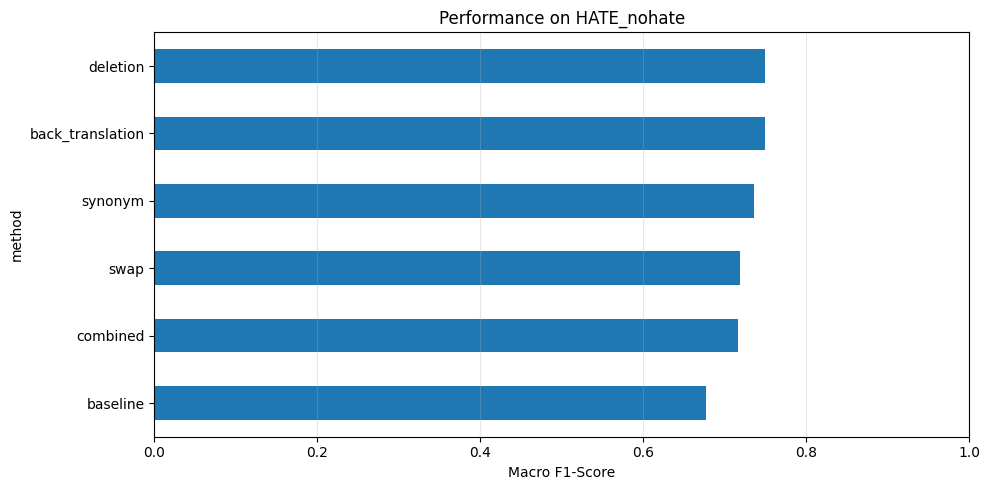

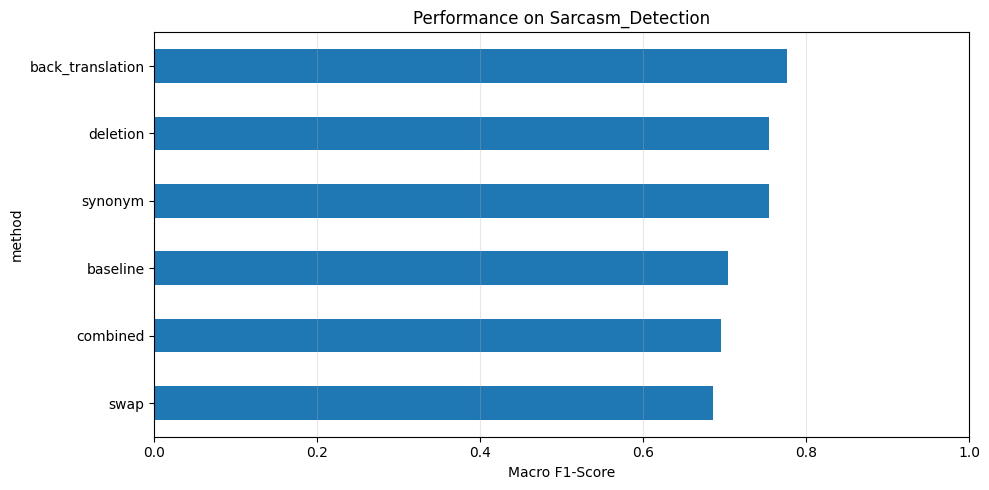

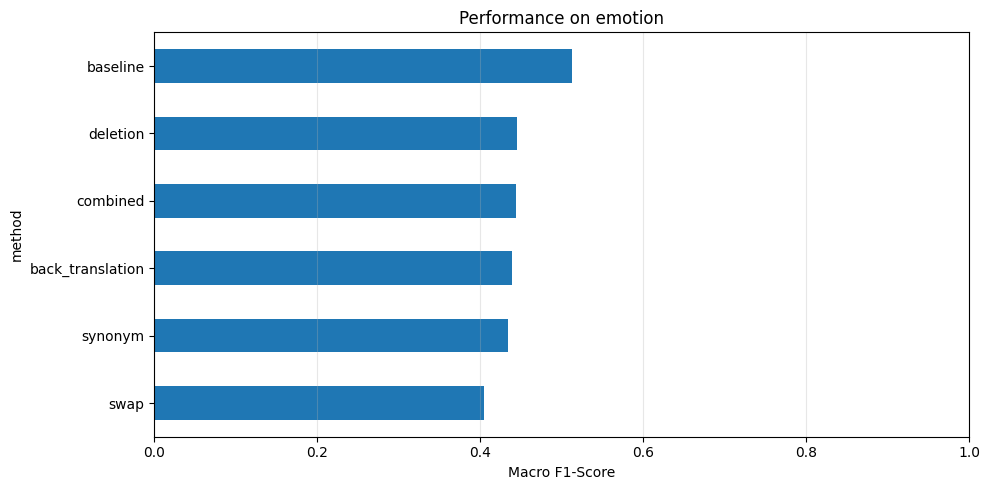

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Combine both results dictionaries
combined_results = {**results, **emotion_results}

# Build DataFrame from combined results
rows = []
for (ds, method), metrics in combined_results.items():
    rows.append({
        "dataset": ds,
        "method": method,
        "accuracy": metrics["eval_accuracy"],
        "f1_macro": metrics["eval_f1_macro"]
    })
df_results = pd.DataFrame(rows)

# Pivot table for analysis
pivot_f1 = df_results.pivot(index="dataset", columns="method", values="f1_macro")
display(pivot_f1)

# Visualization
for ds in pivot_f1.index:
    plt.figure(figsize=(10, 5))
    pivot_f1.loc[ds].sort_values().plot(kind="barh")  # Horizontal bars for better readability
    plt.title(f"Performance on {ds}")
    plt.xlabel("Macro F1-Score")
    plt.xlim([0, 1])  # Consistent scale across plots
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

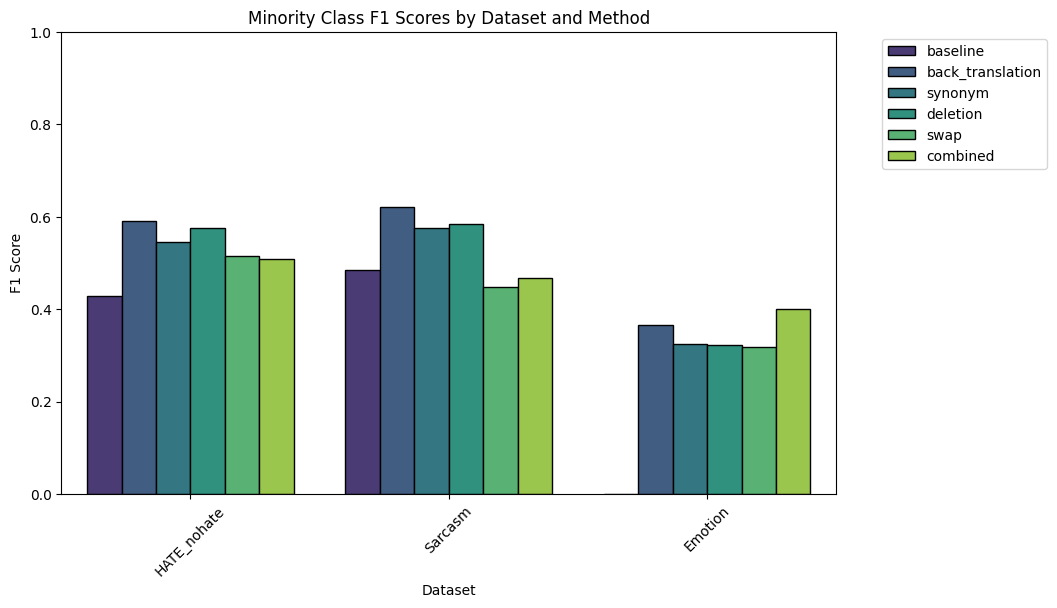

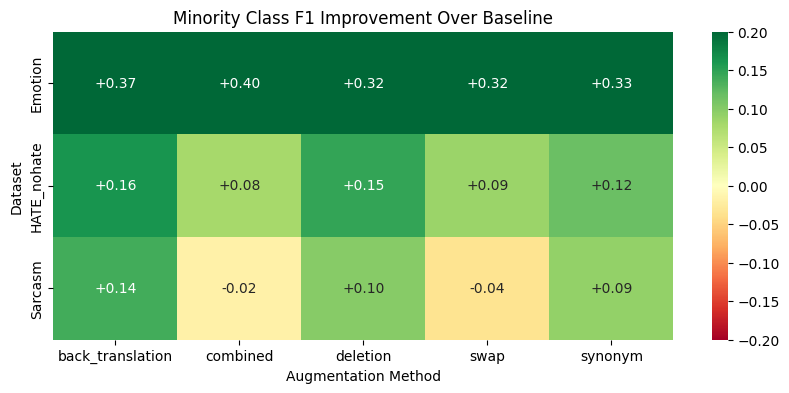

<ipython-input-13-79d99405ee6f>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emotion_df, x='Method', y='Minority_F1', order=emotion_order,


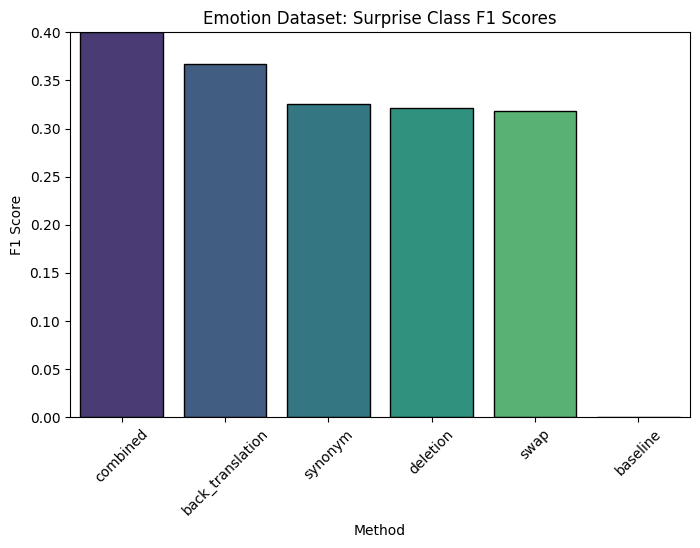

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Manually curated minority class F1 scores from our output
data = {
    'Dataset': ['HATE_nohate', 'HATE_nohate', 'HATE_nohate', 'HATE_nohate', 'HATE_nohate', 'HATE_nohate',
                'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm',
                'Emotion', 'Emotion', 'Emotion', 'Emotion', 'Emotion', 'Emotion'],
    'Method': ['baseline', 'back_translation', 'synonym', 'deletion', 'swap', 'combined',
               'baseline', 'back_translation', 'synonym', 'deletion', 'swap', 'combined',
               'baseline', 'back_translation', 'synonym', 'deletion', 'swap', 'combined'],
    'Minority_F1': [
        # HATE_nohate (class 1)
        0.4286, 0.5909, 0.5455, 0.5753, 0.5152, 0.5079,

        # Sarcasm Detection (class 1)
        0.4839, 0.6216, 0.5758, 0.5833, 0.4483, 0.4667,

        # Emotion (surprise)
        0.0000, 0.3667, 0.3256, 0.3214, 0.3182, 0.4000
    ]
}

df = pd.DataFrame(data)

# Calculate improvement over baseline
baselines = df[df['Method'] == 'baseline'].set_index('Dataset')['Minority_F1']
df = df.join(baselines, on='Dataset', rsuffix='_baseline')
df['Improvement'] = df['Minority_F1'] - df['Minority_F1_baseline']

# 1. Minority F1 Comparison Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Dataset', y='Minority_F1', hue='Method',
            palette='viridis', edgecolor='black')
plt.title('Minority Class F1 Scores by Dataset and Method')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

# 2. Improvement Heatmap
pivot_df = df.pivot(index='Dataset', columns='Method', values='Improvement')
plt.figure(figsize=(10, 4))
sns.heatmap(pivot_df.drop(columns='baseline'), annot=True, fmt="+.2f",
            cmap="RdYlGn", center=0, vmin=-0.2, vmax=0.2)
plt.title('Minority Class F1 Improvement Over Baseline')
plt.xlabel('Augmentation Method')
plt.ylabel('Dataset')
plt.show()

# 3. Emotion Dataset Detailed View
emotion_df = df[df['Dataset'] == 'Emotion'].copy()
emotion_order = emotion_df.sort_values('Minority_F1', ascending=False)['Method']

plt.figure(figsize=(8, 5))
sns.barplot(data=emotion_df, x='Method', y='Minority_F1', order=emotion_order,
            palette='viridis', edgecolor='black')
plt.title('Emotion Dataset: Surprise Class F1 Scores')
plt.ylabel('F1 Score')
plt.ylim(0, 0.4)
plt.xticks(rotation=45)
plt.show()